# Import Packages

In [2]:
import pandas as pd
import numpy as np
import lightgbm as lgb
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, confusion_matrix, roc_auc_score, ConfusionMatrixDisplay, average_precision_score, make_scorer
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical

# Load Data

In [3]:
df = pd.read_csv("../data/prepped_data.csv", low_memory=False, index_col=0).drop_duplicates()

# df = df[df["welcome_discount"] == 1]

# Setup Model

In [4]:
categorical_features = []
continuous_features = []
binary_features = []

# Define a threshold for the maximum number of unique values for a categorical column
max_unique_values_for_categorical = 10

# Iterate through each column to determine if it's categorical, continuous, or binary
for column in df.columns:
    unique_values = df[column].nunique()
    if unique_values == 2:
        # If exactly 2 unique values, treat column as binary
        binary_features.append(column)
    elif (df[column].dtype == 'object' or unique_values <= max_unique_values_for_categorical) and unique_values > 2:
        # If object type or up to the threshold of unique values (and more than 2), treat as categorical
        categorical_features.append(column)
    else:
        # Otherwise, treat as continuous
        continuous_features.append(column)

print(f'Binary Features: {binary_features}')
print(f'Categorical Features: {categorical_features}')
print(f'Continuous Features: {continuous_features}')

for cat in categorical_features:
     df[cat] = df[cat].astype("category")

Binary Features: ['churn', 'last_allrisk basis', 'last_allrisk compleet', 'last_allrisk royaal', 'last_wa-extra', 'fake_alarm', 'policyholder_change', 'n_last_vs_peak', 'lpa']
Categorical Features: ['policy_nr_hashed', 'last_data_year', 'first_data_year', 'control_group', 'last_brand', 'last_type', 'last_fuel_type', 'last_product', 'nr_cars', 'max_nr_coverages', 'last_nr_coverages', 'last_trend_nr_coverages', 'last_year_car_change', 'years_since_last_car_change']
Continuous Features: ['welcome_discount', 'first_premium', 'last_premium', 'first_split', 'last_split', 'last_customer_age', 'last_accident_free_years', 'last_car_value', 'last_age_car', 'last_weight', 'last_postcode', 'last_wettelijke aansprakelijkheid', 'accident_years', 'last_change_premium_abs', 'last_change_premium_perc', 'last_vs_first_split', 'cum_change_premium_abs', 'cum_change_premium_perc']


In [7]:
# cols_to_drop = ["first_split", "first_premium", "nr_cars", "last_type", "last_brand", 'last_weight', 'n_last_vs_peak', 'last_fuel_type', 'last_trend_nr_coverages', 'last_change_premium_abs', 'last_change_premium_perc', 'max_nr_coverages', 'last_nr_coverages',]

X = df[[col for col in df.columns.to_list() if (col not in ["churn", "policy_nr_hashed", "last_data_year", "first_data_year", "control_group", 'welcome_discount'])]]
y = df['churn']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

# Model Selection

In [8]:
clf = lgb.LGBMClassifier(
    objective='binary',
    force_row_wise=True,
    verbosity=-1,
    n_estimators=50,
    is_unbalance=True,
    # learning_rate=0.05,
    reg_alpha=0,
    reg_lambda=0
)

opt = BayesSearchCV(
    clf, 
    {
        "max_depth": Integer(50, 100),
        "num_leaves": Integer(20, 200),
        "min_child_samples": Integer(7, 100),
        "colsample_bytree": Real(0.25, 1),
        "subsample": Real(0.25, 1),
        "subsample_freq": Integer(1, 50),
        "reg_alpha": Real(0, 0.2),
        "reg_lambda": Real(0, 0.2),
        "min_split_gain": Real(0, 0.5),
        "learning_rate": Real(0.01, 0.1),
        "min_data_in_leaf": Integer(1, 20)
    },
    n_iter=50,
    cv=5,
    n_jobs=-1,
    scoring="average_precision",
    random_state = 0,
)

opt.fit(X_train, y_train)

print("Best Score is: ", opt.best_score_, "\n")
print("Best Parameters: ", opt.best_params_, "\n")

lgbm_best = opt.best_estimator_

# Validation

In [213]:
# def custom_f1(y_true, y_pred_prob, threshold=0.5):
#     y_pred = np.abs(np.ceil(np.array(y_pred_prob[:, 1]) - threshold)).astype("int")
#     return f1_score(y_true, y_pred)

# threshold = 0.6
# custom_f1_scorer = make_scorer(custom_f1, response_method='predict_proba', threshold=threshold)

scores_f1 = cross_val_score(clf, X, y, cv=5, scoring='f1', n_jobs=-1)
scores_auc = cross_val_score(clf, X, y, cv=5, scoring='average_precision', n_jobs=-1)
print('CV Average F1 score: {0:0.4f}'.format(np.mean(scores_f1)))
print('CV Average AUC-PR score: {0:0.4f}'.format(np.mean(scores_auc)))

CV Average F1 score: nan
CV Average AUC-PR score: 0.2456
[nan nan nan nan nan]


LightGBM Model F1 score: 0.3037
LightGBM Model AUC-PR score: 0.2220
LightGBM Model AUC-ROC score: 0.7366


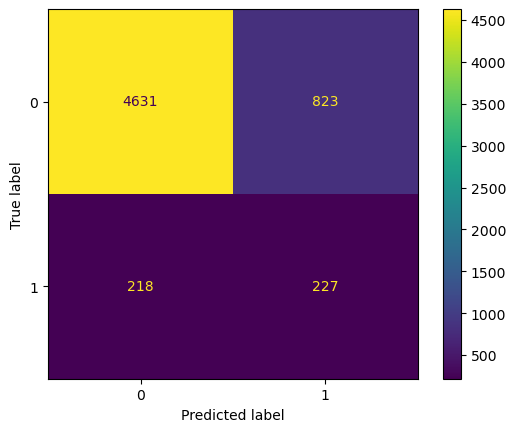

In [205]:
lgbm_best.fit(X_train, y_train)

threshold = 0.6
probabilities = lgbm_best.predict_proba(X_test)[:, 1]
y_pred = np.abs(np.ceil(np.array(probabilities) - threshold)).astype("int")

print('LightGBM Model F1 score: {0:0.4f}'.format(f1_score(y_test, y_pred)))
print('LightGBM Model AUC-PR score: {0:0.4f}'.format(average_precision_score(y_test, lgbm_best.predict_proba(X_test)[:, 1])))
print('LightGBM Model AUC-ROC score: {0:0.4f}'.format(roc_auc_score(y_test, lgbm_best.predict_proba(X_test)[:, 1])))

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=lgbm_best.classes_)
disp.plot()
plt.show()